In [ ]:
# for installing pyspark
!pip install pyspark==3.0.0

# mount your google drive to be able to access files from your google drive !
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import necessary libraries
import pyspark
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Create a SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("RealEstateMarketExploration") \
    .getOrCreate()

# Load the dataset into a DataFrame
file_path = "/content/drive/MyDrive/PYSPARK-COURSE/project_data_real_estate_toulouse_and_suburbs.csv"
sub_df = spark.read.option("delimiter", ";").csv(file_path, header=True, inferSchema=True)

sub_df.show(5)

sub_df.printSchema()

+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|  SaleDate|SaleType| Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
|15/01/2019|    SALE| 95000|   31270|VILLENEUVE TOLOSANE|      2|     0|        HOUSE|        45|     505|
|21/01/2019|    SALE|261700|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        87|     311|
|03/01/2019|    SALE|101000|   31270|VILLENEUVE TOLOSANE|      2|     1|    APARTMENT|        44|       0|
|11/01/2019|    SALE| 59500|   31270|VILLENEUVE TOLOSANE|      1|     1|    APARTMENT|        26|       0|
|15/01/2019|    SALE|179000|   31270|VILLENEUVE TOLOSANE|      4|     0|        HOUSE|        95|     263|
+----------+--------+------+--------+-------------------+-------+------+-------------+----------+--------+
only showing top 5 rows

root
 |-- Sa

In [ ]:
#Create an schema for the df
from pyspark.sql.types import *
from pyspark.sql.functions import *
data_schema =StructType ( [StructField("_c0", IntegerType(), True),
                           StructField("SaleDate", DateType(), True),
                           StructField("SaleType", StringType(), True),
                           StructField("Price", DoubleType(), True),
                           StructField("PostCode", IntegerType(), True),
                           StructField("City", StringType(), True),
                           StructField("NbRooms", IntegerType(), True),
                           StructField("NbLots", IntegerType(), True),
                           StructField("ResidenceType", StringType(), True),
                           StructField("LivingArea", IntegerType(), True),
                           StructField("LandArea", IntegerType(), True)]
                        )

In [ ]:
# register the sub_df DataFrame as a temporary view with the name 'sub' for further spark sql queries

sub_df.createOrReplaceTempView('sub')

# Analysis

First, let's have a general look of this dataset.

The **amount of real estates in Toulouse and Suburbs are 80,118**.

In [ ]:
# what is the total number of sales orders of the company ?

total_number_sales_df = spark.sql('SELECT COUNT(SaleDate) FROM sub')

total_number_sales_df.show()

+---------------+
|count(SaleDate)|
+---------------+
|          80118|
+---------------+



and the total sales of estates in each cities are stated in the table down below with **Toulouse having the highest amount, follwed by Blagnac and Cugnaux**.

In [ ]:
# what is the total sales of estates (sum of all sales) per City ?

total_sales_city_df = spark.sql("SELECT City, SUM(Price) AS total_sales FROM sub GROUP BY City ORDER BY total_sales DESC")

total_sales_city_df.show()

+--------------------+---------------+
|                City|    total_sales|
+--------------------+---------------+
|            TOULOUSE|3.1724699371E10|
|             BLAGNAC|  2.524100608E9|
|             CUGNAUX|  1.006232069E9|
|          SAINT-JEAN|   9.28005421E8|
|           COLOMIERS|   8.74356774E8|
|       TOURNEFEUILLE|   8.11805038E8|
|RAMONVILLE-SAINT-...|   5.49122602E8|
|          AUCAMVILLE|   4.56731919E8|
|              PIBRAC|   4.50102673E8|
|               BALMA|   4.10830562E8|
|               MURET|   3.78442364E8|
|    CASTANET TOLOSAN|    3.4270334E8|
|  PLAISANCE DU TOUCH|   3.32162675E8|
|SAINT-ORENS-DE-GA...|   3.13708858E8|
|             L UNION|   2.67684927E8|
| VILLENEUVE TOLOSANE|   2.13029319E8|
|        CORNEBARRIEU|   1.86722892E8|
|           BEAUZELLE|   1.30204004E8|
|            LEGUEVIN|   1.27386157E8|
|  PORTET SUR GARONNE|   1.23859407E8|
+--------------------+---------------+
only showing top 20 rows



# Analysis 1: The evolution of the prices

This analysis tracks the changes in property prices over time, providing insights into the overall trend in the real estate market in Toulouse and ohter suburbs. Understanding how prices evolve can help stakeholders, such as real estate agencies or property investors, make informed decisions about buying, selling, or investing in properties.

In the graph down below, we can see that in the early 2015, there is a HUGE spike in the evolution of prices.

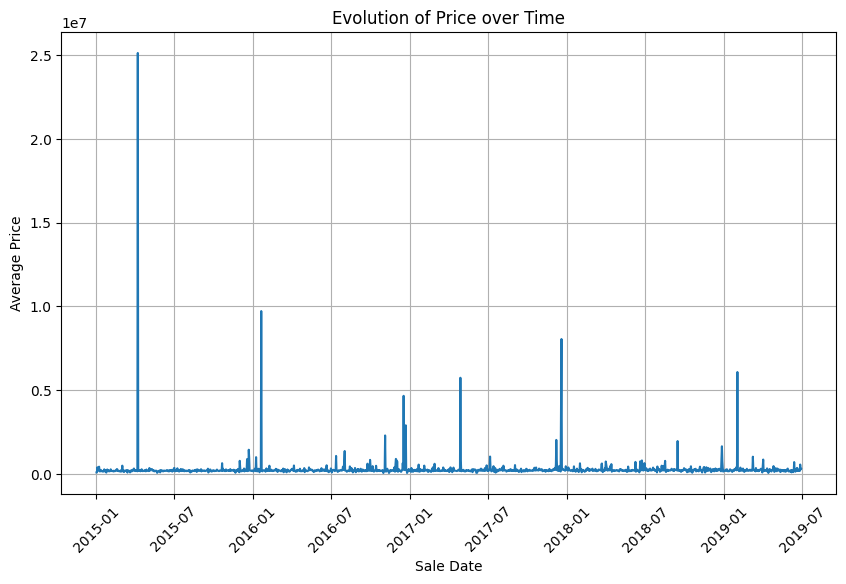

In [ ]:
from pyspark.sql.functions import avg
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.sql.functions import to_date
import pandas as pd

# Convert 'SaleDate' column to date type
real_estate_df = sub_df.withColumn('SaleDate', to_date(sub_df['SaleDate'], 'dd/MM/yyyy'))

# Group by 'SaleDate' and calculate the average price for each date
price_trend_df = real_estate_df.groupBy('SaleDate').avg('Price').orderBy('SaleDate')

# Convert the result to a Pandas DataFrame for plotting
price_trend_pd = price_trend_df.toPandas()

# Plot the price trend over time
plt.figure(figsize=(10, 6))
plt.plot(price_trend_pd['SaleDate'], price_trend_pd['avg(Price)'])
plt.title('Evolution of Price over Time')
plt.xlabel('Sale Date')
plt.ylabel('Average Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Analysis 2: The price distribution

By looking at the price distribution, it helps us understand what prices are common, spot any unusual prices, and see if there are different groups of properties with different prices.

Since the bar chart is the highest at value 0, it is safe to assume that the majority of properties have a very low price. A high frequency of low prices could indicate affordability and provide opportunities for certain buyers, it might also suggest challenges in the real estate market related to property values and market dynamics.

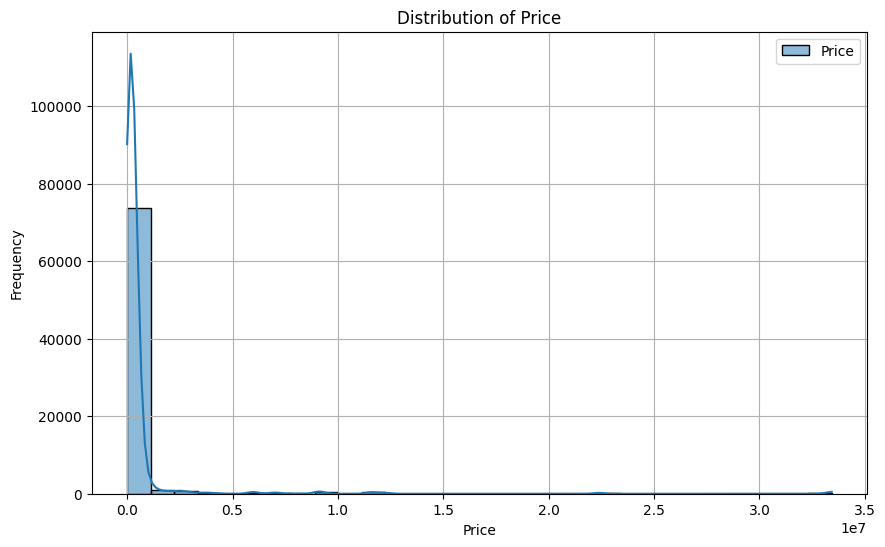

In [ ]:
# Analyze distribution of key variables
# Distribution of price
plt.figure(figsize=(10, 6))
sns.histplot(sub_df.select('Price').toPandas(), bins=30, kde=True)
plt.title("Distribution of Price")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Analysis 3: Identifications of Sales Outliers

The code calculates the Z-score for the prices of properties in the dataset and identifies outliers based on a predefined threshold.

Z-score measures how far away a particular data point is from the average of the dataset, in units of standard deviation: A positive Z-score means the data point is above the average, while a negative Z-score means it's below the average.

As we can see in the output below,the highest Z-Score is 4.57, which means it is above average.

In [ ]:
from pyspark.sql.functions import col, stddev, mean

# Calculate mean and standard deviation of prices
mean_price = sub_df.select(mean("Price")).collect()[0][0]
stddev_price = sub_df.select(stddev("Price")).collect()[0][0]

# Calculate Z-score
z_score_threshold = 3
sub_df_with_zscore = sub_df.withColumn("Z_Score", (col("Price") - mean_price) / stddev_price)

# Filter outliers
outliers_df = sub_df_with_zscore.filter(abs(col("Z_Score")) > z_score_threshold)

# Show the outliers
outliers_df.show()


+----------+--------+-----------+--------+-------------------+-------+------+-------------+----------+--------+------------+------------------+
|  SaleDate|SaleType|      Price|PostCode|               City|NbRooms|NbLots|ResidenceType|LivingArea|LandArea|CityCategory|           Z_Score|
+----------+--------+-----------+--------+-------------------+-------+------+-------------+----------+--------+------------+------------------+
|08/04/2015|    SALE|1.1678344E7|   31270|VILLENEUVE TOLOSANE|      4|     1|    APARTMENT|        85|       0|   High Cost| 4.568210513095387|
|08/04/2015|    SALE|1.1678344E7|   31270|VILLENEUVE TOLOSANE|      3|     1|    APARTMENT|        62|       0|   High Cost| 4.568210513095387|
|08/04/2015|    SALE|1.1678344E7|   31270|VILLENEUVE TOLOSANE|      4|     1|    APARTMENT|        85|       0|   High Cost| 4.568210513095387|
|08/04/2015|    SALE|1.1678344E7|   31270|VILLENEUVE TOLOSANE|      3|     1|    APARTMENT|        62|       0|   High Cost| 4.568210513

# Analysis 4: Difference between Apartments and Houses

By comparing the average prices of apartments and houses, stakeholders can gain insights into the preferences and demand for different types of residential properties.

As we can see here, apartments has higher average price with 582,729€ compared to houses with 446,805€.

In [ ]:
# Calculate average price for apartments and houses
avg_price_by_residence = sub_df.groupBy("ResidenceType").avg("Price").orderBy("ResidenceType")

# Show the result
avg_price_by_residence.show()

+-------------+------------------+
|ResidenceType|        avg(Price)|
+-------------+------------------+
|    APARTMENT| 582729.3670867011|
|        HOUSE|446805.24561909155|
+-------------+------------------+



# Analysis 5: Difference between type of sales (Sale vs Sale Before Completion)

Examining the differences between various types of sales (in this case Sale vs Sale Before Completion), provides insights into the different market segments and their respective dynamics. By understanding these differences, it will help stakeholders tailor their strategies and offerings to better meet the needs and preferences of different buyer segments.

From the table we have donw below, we can see that "Sale" has much higher average price compared to the other one, meaning that this type is much more demanded by customers.

In [ ]:
# Calculate average price for different types of sales
avg_price_by_sale_type = sub_df.groupBy("SaleType").avg("Price").orderBy("SaleType")

# Show the result
avg_price_by_sale_type.show()

+--------------------+------------------+
|            SaleType|        avg(Price)|
+--------------------+------------------+
|                SALE| 619162.3637409088|
|SALE BEFORE COMPL...|214115.88994277653|
+--------------------+------------------+



# Analysis 6: Difference between Toulouse and its Suburbs

Since we are living in Toulouse, why not compare the difference between Toulouse and the other suburbs?n We decided to compare the average price to see if Toulouse has a lower or higher scales in demand.

By looking at the table and bar chart down below, we can see that Toulouse has the 3rd highest average price compared to other with 634,151€. It is safe to assume that Toulouse has one of the highest demand of estate, losing only to Saint-Jean and Pibrac.

+--------------------+------------------+
|                City|        avg(Price)|
+--------------------+------------------+
|          SAINT-JEAN|  863260.856744186|
|              PIBRAC| 836622.0687732341|
|            TOULOUSE| 634151.5455853839|
|             CUGNAUX| 579626.7678571428|
|    VIEILLE TOULOUSE|          570051.5|
|             BLAGNAC|507254.94533762056|
|          AUCAMVILLE| 472807.3695652174|
|RAMONVILLE-SAINT-...|434089.01343873516|
| VILLENEUVE TOLOSANE| 353282.4527363184|
|       TOURNEFEUILLE|347073.55194527574|
|  PLAISANCE DU TOUCH|335517.85353535356|
|           COLOMIERS|323835.84222222224|
|               BALMA|306818.94100074685|
|              LABEGE| 303852.6934306569|
|             L UNION|297758.53948832036|
|        CORNEBARRIEU|296385.54285714286|
|  AUZEVILLE-TOLOSANE|289053.77040816325|
|SAINT-ORENS-DE-GA...|285969.78851412947|
|               MURET|279293.25756457564|
|    CASTANET TOLOSAN| 266280.7614607615|
+--------------------+------------

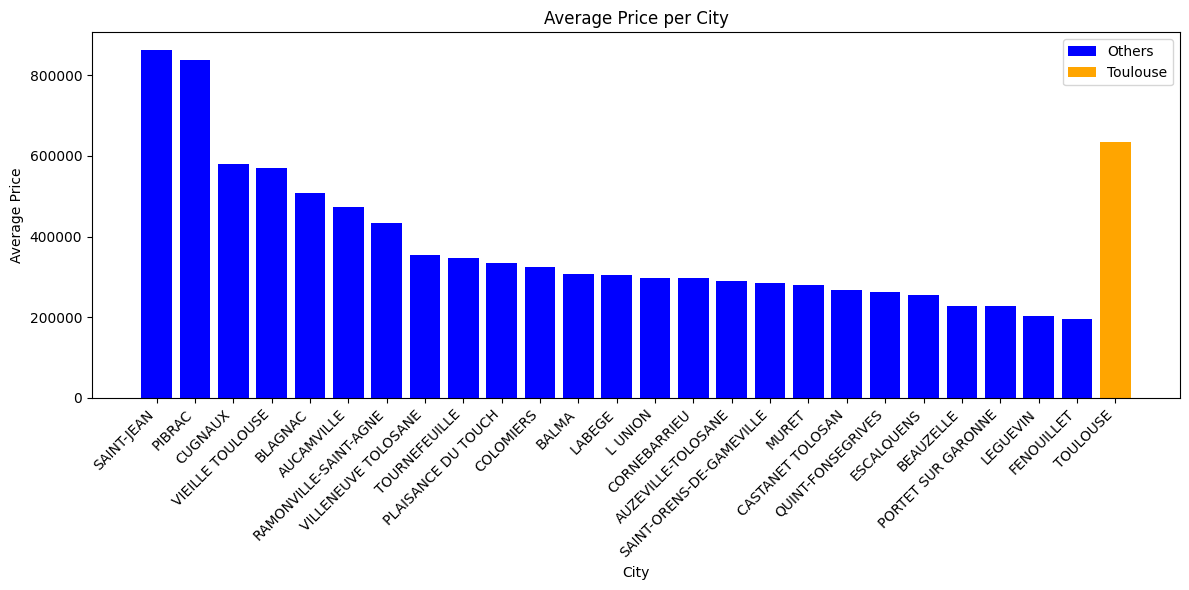

In [ ]:
from pyspark.sql.functions import desc

# Calculate average price per city and order by descending city name
avg_price_by_location_desc = sub_df.groupBy("City").avg("Price").orderBy(desc("avg(Price)"))

# Show the result
avg_price_by_location_desc.show()

#--------------------------------------------------------------------------------------------
# Calculate average price per city
avg_price_per_city = sub_df.groupBy("City").avg("Price").orderBy(desc("avg(Price)"))

# Convert DataFrame to Pandas for plotting
avg_price_per_city_pd = avg_price_per_city.toPandas()

# Separate Toulouse from other cities
toulouse_avg_price = avg_price_per_city_pd[avg_price_per_city_pd["City"] == "TOULOUSE"]
other_cities_avg_price = avg_price_per_city_pd[avg_price_per_city_pd["City"] != "TOULOUSE"]

# Plot average price per city
plt.figure(figsize=(12, 6))
plt.bar(other_cities_avg_price["City"], other_cities_avg_price["avg(Price)"], color='blue', label='Others')
plt.bar(toulouse_avg_price["City"], toulouse_avg_price["avg(Price)"], color='orange', label='Toulouse')
plt.title("Average Price per City")
plt.xlabel("City")
plt.ylabel("Average Price")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()



# Analysis 7: High cost, Low cost or Emerging cities

This analysis categorizes cities based on their property prices, identifying high-cost, low-cost, and emerging cities.

We can see from the table and graphs down below that Emerging city is the highest comparing to the other 2.

This indicates that there is a significant number of cities that are considered to be in the process of development or growth within the real estate market.

+------------+-----+
|CityCategory|count|
+------------+-----+
|    Emerging|38521|
|   High Cost|19310|
|    Low Cost|19274|
+------------+-----+



<ipython-input-150-cc3dd5d352f6>:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CityCategory', data=sub_df.toPandas(), order=['Low Cost', 'Emerging', 'High Cost'], palette={'Low Cost': 'blue', 'Emerging': 'green', 'High Cost': 'red'})


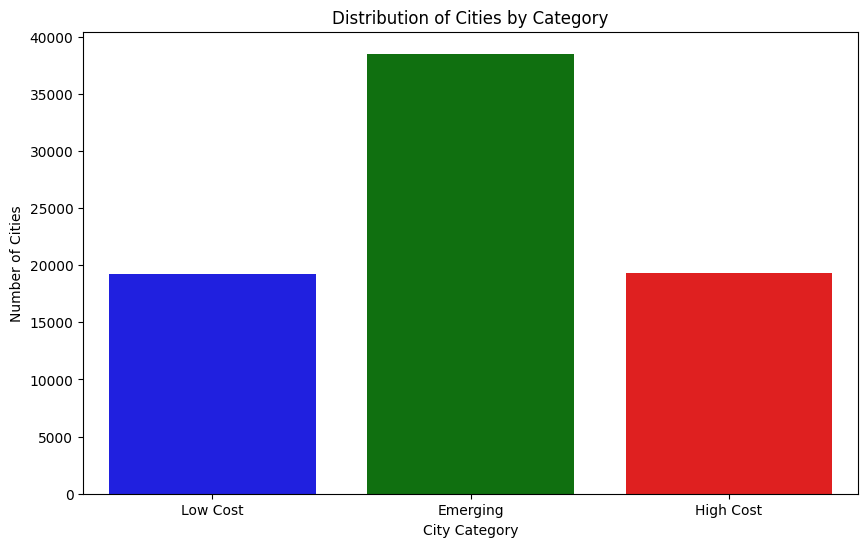

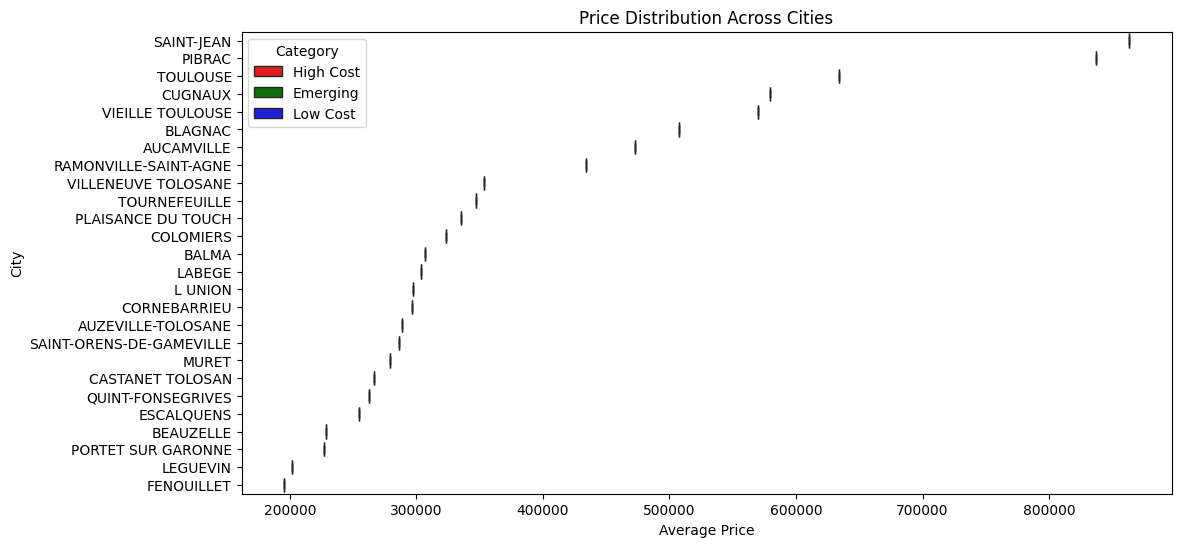

In [ ]:
from pyspark.sql.functions import col, when
from pyspark.sql import functions as F

# Calculate quantiles for average price
quantiles = sub_df.groupBy().agg(F.expr('percentile_approx(Price, array(0.25, 0.75))').alias('quantiles')).collect()[0]['quantiles']

# Extract low and high cost thresholds from quantiles
low_cost_threshold = quantiles[0]
high_cost_threshold = quantiles[1]

# Create a new column to categorize cities
sub_df = sub_df.withColumn("CityCategory",
                           when(col("Price") >= high_cost_threshold, "High Cost")
                           .when(col("Price") <= low_cost_threshold, "Low Cost")
                           .otherwise("Emerging"))

# Group by city category and count the number of occurrences
city_category_counts = sub_df.groupBy("CityCategory").count().orderBy("CityCategory")

# Show the result
city_category_counts.show()


#-----------------------------------------------------------------------------------------------------

# Group by city and calculate average price for each city
city_prices_df = sub_df.groupBy('City').avg('Price').orderBy('avg(Price)', ascending=False)

# Convert the result to a Pandas DataFrame for plotting
city_prices_pd = city_prices_df.toPandas()

# Define thresholds for high-cost, low-cost, and emerging cities
high_cost_threshold = city_prices_pd['avg(Price)'].quantile(0.75)
low_cost_threshold = city_prices_pd['avg(Price)'].quantile(0.25)

# Categorize cities based on thresholds
city_prices_pd['Category'] = 'Emerging'
city_prices_pd.loc[city_prices_pd['avg(Price)'] >= high_cost_threshold, 'Category'] = 'High Cost'
city_prices_pd.loc[city_prices_pd['avg(Price)'] <= low_cost_threshold, 'Category'] = 'Low Cost'

# Plot the distribution of cities based on categories
plt.figure(figsize=(10, 6))
sns.countplot(x='CityCategory', data=sub_df.toPandas(), order=['Low Cost', 'Emerging', 'High Cost'], palette={'Low Cost': 'blue', 'Emerging': 'green', 'High Cost': 'red'})
plt.title('Distribution of Cities by Category')
plt.xlabel('City Category')
plt.ylabel('Number of Cities')
plt.show()

#-----------------------------------------------------------------------------------------------------------

# Group by city and calculate average price for each city
city_prices_df = sub_df.groupBy('City').avg('Price').orderBy('avg(Price)', ascending=False)

# Convert the result to a Pandas DataFrame for plotting
city_prices_pd = city_prices_df.toPandas()

# Define thresholds for high-cost, low-cost, and emerging cities
high_cost_threshold = city_prices_pd['avg(Price)'].quantile(0.75)
low_cost_threshold = city_prices_pd['avg(Price)'].quantile(0.25)

# Categorize cities based on thresholds
city_prices_pd['Category'] = 'Emerging'
city_prices_pd.loc[city_prices_pd['avg(Price)'] >= high_cost_threshold, 'Category'] = 'High Cost'
city_prices_pd.loc[city_prices_pd['avg(Price)'] <= low_cost_threshold, 'Category'] = 'Low Cost'

# Plot the distribution of prices across different cities
plt.figure(figsize=(12, 6))
sns.boxplot(x='avg(Price)', y='City', data=city_prices_pd, hue='Category', palette={'High Cost': 'red', 'Low Cost': 'Blue', 'Emerging': 'green'})
plt.title('Price Distribution Across Cities')
plt.xlabel('Average Price')
plt.ylabel('City')
plt.legend(title='Category')
plt.show()


# Conclusion

In conclusion, we have some pretty good analysis from this project and to summarize them:

1. Price Trends: Prices of properties fluctuated over time, showing periods of both growth and decline.

2. Outliers: Some sales transactions stood out as outliers, indicating unusually high or low prices compared to the norm.

3. Price Variation: Property prices varied across different cities or areas, with some locations being more expensive than others.

4. Property Types: Apartments and houses had differing price ranges, with one type often being more expensive than the other.

5. Sales Dynamics: Various types of sales transactions were observed, reflecting different market dynamics or buyer preferences.

6. Urban vs. Suburban: Price disparities were noted between Toulouse and its suburbs, highlighting differences in affordability and demand.

7. Market Segmentation: Cities were categorized based on price thresholds, identifying areas as high-cost, low-cost, or emerging markets.

Overall, this analysis provides valuable insights for stakeholders to understand market trends, identify investment opportunities, and make informed decisions in the Toulouse real estate market and its suburbs